problems: can't tell where people live vs work
some bg are uninhabited but have calls / have more calls than people
presumably from people who live elsewhere
so making a calls per population stat is impossible


also, spatial autocorrelation is a thing

In [16]:
import os

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import statsmodels.formula.api as smf
from libpysal.weights import Queen, KNN
from esda.moran import Moran

from pykrige.ok import OrdinaryKriging

from air_brain.data.get_data import DATA_DIR
from air_brain.util.air import PM25
from air_brain.util.od import od

bg_file = os.path.join(DATA_DIR, "tl_2010_42003_bg10", "tl_2010_42003_bg10.shp")
ems_file = os.path.join(DATA_DIR, "ems.csv")

In [2]:
# TODO put this elsewhere
# aggregate all years EPA EJ data
years = range(2015, 2025)
dfs = list()
for year in years:
    df = pd.read_csv(os.path.join(DATA_DIR, "epa_ej", "{}.csv".format(year)))
    df = df[['ID', 'totalpop', 'area', 
             'PM25', 'O3', 'traffic', 'dpm',
             'poc', 'lowincome']]
    df["year"] = year
    dfs.append(df)
pm25 = pd.concat(dfs)
pm25

,ID,totalpop,area,PM25,O3,traffic,dpm,poc,lowincome,year
0,420034705021,1342.0,1.915879e+06,12.158395,48.498314,2.717136e+02,NaN,0.049925,0.173193,2015
1,420035641001,485.0,2.508694e+06,12.142007,48.667571,3.524793e+02,NaN,0.028866,0.041237,2015
2,420034722003,754.0,5.849154e+05,12.208334,48.193514,1.451662e+02,NaN,0.072944,0.205570,2015
3,420031306001,764.0,6.321158e+05,12.229263,47.334898,6.467024e+01,NaN,1.000000,0.683246,2015
4,420035642002,1128.0,6.130349e+06,12.190916,45.809762,1.315391e+01,NaN,0.053191,0.267730,2015
...,...,...,...,...,...,...,...,...,...,...
389,42003981000,0.0,1.378279e+06,9.023411,64.754700,2.308631e+06,0.245892,0.000000,0.000000,2024
390,42003981100,0.0,8.759890e+05,9.108626,64.244420,NaN,NaN,0.000000,0.000000,2024
391,42003981200,0.0,5.970230e+05,8.938463,64.135080,NaN,NaN,0.000000,0.000000,2024
392,42003981800,385.0,2.128687e+06,9.081310,64.867940,2.062348e+06,0.228635,0.288312,0.789474,2024


In [3]:
bgs = gpd.read_file(bg_file)
bgs["ID"] = bgs.GEOID10.astype(int)
bgs = bgs[["ID", "geometry"]]

In [4]:
ems = pd.read_csv(ems_file)
ems.head()

,_id,call_id_hash,service,priority,priority_desc,call_quarter,call_year,description_short,city_code,city_name,geoid,census_block_group_center__x,census_block_group_center__y
0,1,000015F42010D7E9BFD0478A34A274,EMS,E4,EMS Basic Life Support Assistance response (i....,Q2,2019,FALL,WBG,WILKINSBURG,4.200356e+11,-79.865320,40.450306
1,2,0000B80868F29646B49B6BBEACF327,EMS,E3,EMS Standard Basic Life Support response,Q2,2017,BACK PAIN,PGH,PITTSBURGH,4.200356e+11,-80.058297,40.458065
2,3,000144D3D698BD201ADA401DB80C22,EMS,E5,All administrative mark outs,Q2,2019,NON EMERGENCY TRANSPORT,PGH,PITTSBURGH,4.200322e+11,-80.005155,40.457261
3,4,00027A35111A3580959D7A51E11A6B,EMS,E3,EMS Standard Basic Life Support response,Q4,2018,TRAUMA,PGH,PITTSBURGH,4.200313e+11,-79.891090,40.457802
4,5,0002E6494A455866F44A1ECE8426D7,EMS,E2,EMS Standard Advanced Life Support response,Q4,2016,PSYCH,WBG,WILKINSBURG,4.200356e+11,-79.865320,40.450306


In [5]:
# EMS data, aggregated by year, census block group, and call description
# TODO might also want call severity
ems_counts = ems.groupby(['call_year', 'geoid', 'description_short']).agg({'service': 'count'}).reset_index()
ems_counts.rename(columns={'call_year': 'year', 'geoid': 'ID'}, inplace=True)
# what fraction of calls for this year for this bg was this type of call?
total_calls = ems_counts.groupby(['year', 'ID']).agg({'service': 'sum'}).reset_index().rename(columns={'service': 'total_count'})
ems_counts = ems_counts.merge(total_calls, on=['year', 'ID'], how='left')
ems_counts['call_frac'] = ems_counts.service / ems_counts.total_count
# add in EPA EJ data
ems_counts = ems_counts.merge(pm25, on=['ID', 'year'], how='inner')
# add in geometry
ems_counts = bgs.merge(ems_counts, on='ID', how='right')
ems_counts.head()

,ID,geometry,year,description_short,service,total_count,call_frac,totalpop,area,PM25,O3,traffic,dpm,poc,lowincome
0,420030103001,"POLYGON ((-79.97547 40.43437, -79.97583 40.434...",2015,ABDOMINAL PAIN,17,462,0.036797,1189.0,911211.798603,12.26465,47.786163,1871.134846,NaN,0.592094,0.0
1,420030103001,"POLYGON ((-79.97547 40.43437, -79.97583 40.434...",2015,ASSAULT,5,462,0.010823,1189.0,911211.798603,12.26465,47.786163,1871.134846,NaN,0.592094,0.0
2,420030103001,"POLYGON ((-79.97547 40.43437, -79.97583 40.434...",2015,BACK PAIN,1,462,0.002165,1189.0,911211.798603,12.26465,47.786163,1871.134846,NaN,0.592094,0.0
3,420030103001,"POLYGON ((-79.97547 40.43437, -79.97583 40.434...",2015,BREATHING,30,462,0.064935,1189.0,911211.798603,12.26465,47.786163,1871.134846,NaN,0.592094,0.0
4,420030103001,"POLYGON ((-79.97547 40.43437, -79.97583 40.434...",2015,CHEST PAIN,41,462,0.088745,1189.0,911211.798603,12.26465,47.786163,1871.134846,NaN,0.592094,0.0


<Axes: >

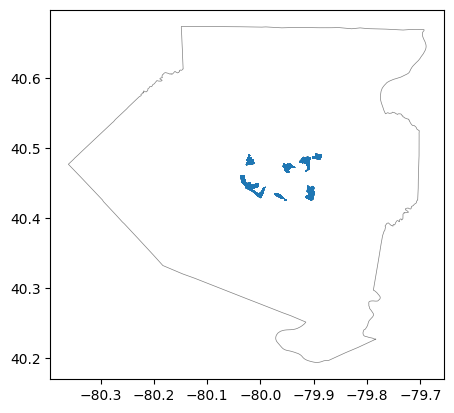

In [6]:
# where are census block groups without population?
# e.g. Chateau, an area of all warehouses across the river from downtown
no_pop = ems_counts.loc[ems_counts.totalpop == 0]
county_file = os.path.join(DATA_DIR, "county.geojson")
county_df = gpd.read_file(county_file)
ax = county_df.boundary.plot(color="grey", linewidth=0.5)
no_pop.plot(ax=ax)

In [7]:
ems_counts.description_short.value_counts().index.tolist()

['SICK',
 'FALL',
 'BREATHING',
 'UNCONSCIOUS',
 'CHEST PAIN',
 'UNKNOWN',
 'ABDOMINAL PAIN',
 'CONVULSION',
 'OVERDOSE',
 'POSSIBLE OR OBVIOUS DEATH',
 'PSYCH',
 'STROKE',
 'HEART',
 'TRAUMA',
 'DIABETIC',
 'BACK PAIN',
 'HEMORRHAGE',
 'ASSAULT',
 'CO OR HAZMAT ISSUE',
 'TRAFFIC -WITH INJURIES',
 'ALLERGIES',
 'DWELLING FIRE',
 'TRAFFIC - UNKNOWN STATUS',
 'HEADACHE',
 'Removed',
 'NATURAL GAS ISSUE',
 'PREGNANCY',
 'TRAFFIC - UNKNOWN STATUS (UNK # INJ)',
 'COMMERCIAL OR APARTMENT BLDG FIRE',
 'RQST ASST  EMS',
 'GUNSHOT, STABBING, OR OTHER WOUND',
 'MUTUAL AID',
 'TRAFFIC - OTHER HAZARDS',
 'TRAFFIC - 1ST PARTY/NOT DANGEROUS INJ',
 'WIRES FIRE/ARCING/UNK DANGER',
 'RQST ASST EMS',
 'CHOKING',
 'TRAFFIC-HIGH MECHANISM (ROLLOVER)',
 'POSS DWELLING FIRE',
 'FIRE ALARM RES BLDG',
 'FIRE ALARM COM BLDG',
 'EYE INJURY',
 'TRAFFIC-HIGH MECHANISM (AUTO-PEDESTRIAN)',
 'TRAFFIC-HIGH MECHANISM (BIKE/MOTORCYCLE)',
 'ANIMAL BITES',
 'VEHICLE FIRE',
 'DETAIL',
 'WATER CONDITION INSIDE',
 'POSS COM

# one call type, linear mixed model grouped by census block group

In [8]:
subset = ems_counts.loc[(ems_counts.description_short == 'BACK PAIN')].copy()

<Axes: xlabel='PM25', ylabel='service'>

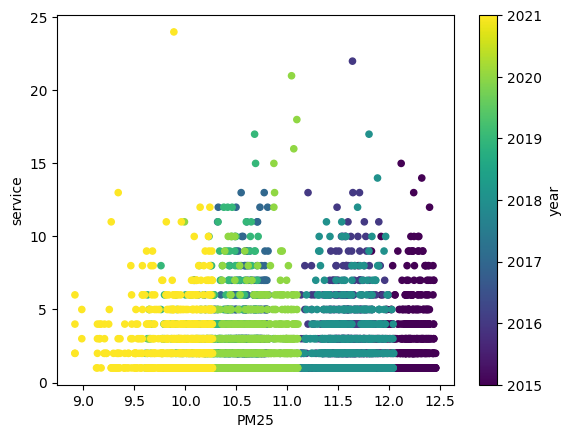

In [9]:
pd.DataFrame(subset).plot(x='PM25', y='service', kind='scatter', c='year', cmap='viridis')

In [10]:
md = smf.mixedlm("service ~ PM25 + totalpop + lowincome + poc", subset, groups=subset.ID)
mdf = md.fit()
mdf.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: service    
No. Observations: 5169    Method:             REML       
No. Groups:       1017    Scale:              2.7164     
Min. group size:  1       Log-Likelihood:     -10543.5920
Max. group size:  7       Converged:          Yes        
Mean group size:  5.1                                    
----------------------------------------------------------
             Coef.  Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------
Intercept    0.644     0.362  1.777  0.076  -0.066   1.354
PM25         0.048     0.032  1.522  0.128  -0.014   0.110
totalpop     0.001     0.000  9.145  0.000   0.000   0.001
lowincome    1.767     0.229  7.709  0.000   1.318   2.216
poc          0.385     0.188  2.053  0.040   0.018   0.753
Group Var    1.312     0.054                              
=========================================================

"""

In [11]:
md = smf.mixedlm("call_frac ~ PM25 + totalpop + lowincome + poc", subset, groups=subset.ID)
mdf = md.fit()
mdf.summary()

/home/eli/.cache/pypoetry/virtualenvs/air-brain-tDLovGh8-py3.12/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
         Mixed Linear Model Regression Results
========================================================
Model:            MixedLM Dependent Variable: call_frac 
No. Observations: 5169    Method:             REML      
No. Groups:       1017    Scale:              0.0001    
Min. group size:  1       Log-Likelihood:     16229.7819
Max. group size:  7       Converged:          Yes       
Mean group size:  5.1                                   
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept      0.016    0.002  7.710 0.000  0.012  0.020
PM25           0.000    0.000  2.400 0.016  0.000  0.001
totalpop      -0.000    0.000 -8.468 0.000 -0.000 -0.000
lowincome     -0.003    0.001 -2.619 0.009 -0.006 -0.001
poc           -0.001    0.001 -1.228 0.219 -0.003  0.001
Group Var      0.000    0.000                           
========================================================

"""

# are certain call types clustered? where?

In [12]:
call_types = ['BREATHING', 'CHEST PAIN', 'HEART', 'STROKE', 'PSYCH', 'OVERDOSE']
year = [2017]

<Axes: >

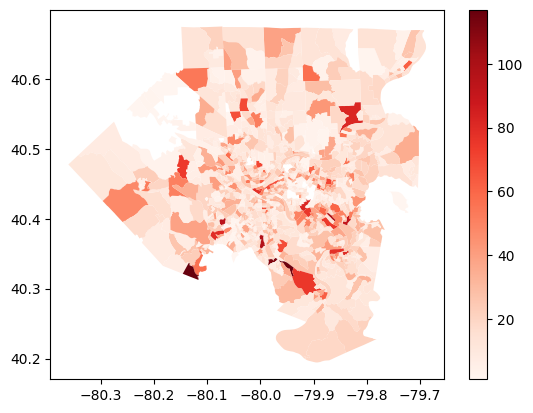

In [13]:
subset = ems_counts.loc[(ems_counts.description_short == 'BREATHING') &
                         ems_counts.year.isin(year)].copy()
subset.plot(column="service", legend=True, cmap="Reds")

In [14]:
# Queen contiguity
w = Queen.from_dataframe(subset)

/tmp/ipykernel_14888/1574300054.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(subset)
/home/eli/.cache/pypoetry/virtualenvs/air-brain-tDLovGh8-py3.12/lib/python3.12/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 3 disconnected components.
 There are 2 islands with ids: 486, 811.
  W.__init__(self, neighbors, ids=ids, **kw)


In [18]:
# is there spatial structure???? yes
res = Moran(subset.service, w)
print(res.I)
print(res.p_sim)

0.106539145634838
0.001
